In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta,datetime
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('transaction_preprocess.csv', encoding = "ISO-8859-1")
# Convert InvoiceDate from object to datetime format
df['createdAt'] = pd.to_datetime(df['createdAt'])
snapshot_date = df['createdAt'].max() + timedelta(days=1)
df['payerAccNo'] = df['payerAccountNumber']
df.drop(["channel_master","channel_amex","channel_visa","initialized_api","initialized_session","initialized_plugin","initialized_ext_api","initialized_ipg"], inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256294 entries, 0 to 256293
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Unnamed: 0                    256294 non-null  int64         
 1   payerAccountNumber            256294 non-null  int64         
 2   payerIdTransformed            256294 non-null  int64         
 3   payeeIdTransformed            256294 non-null  int64         
 4   originalAmount                256294 non-null  float64       
 5   createdAt                     256294 non-null  datetime64[ns]
 6   transaction_date              256294 non-null  object        
 7   transaction_time              256294 non-null  object        
 8   issuer_bank                   256294 non-null  int64         
 9   ip_address                    256294 non-null  int64         
 10  browser                       256294 non-null  int64         
 11  funding_metho

In [3]:
last_month_transacts_df = df.loc[(df['createdAt'] > (max(df['createdAt']) - timedelta(30)))]
last_week_transacts_df = df.loc[(df['createdAt'] > (max(df['createdAt']) - timedelta(7)))]

In [4]:
class FeatureAggregatorFunctions:
     #period 1-yearly, 2-monthly 3-weekly
    def __init__(self,period = 1):
        self.period = period
        
    def generate_features(self,x):
        data_process = x.groupby(['payerIdTransformed','payerAccNo'], as_index=False).agg({
        'createdAt': lambda x: (snapshot_date - x.max()).days,
        'payerAccountNumber': 'count',
        'originalAmount':'sum',
        'payeeIdTransformed':'count',
        'funding_method': 'sum',
        'secure_3ds':'sum',
        'success_3ds':'sum',
        'browser':'count',
        'status':'sum',
        'type':'sum',
        'currency':'sum',
        'amount_high':'sum',
        'suspicious_time':'sum',
        'high_risk_credit_transaction':'sum',
        'bank_approved':'sum',
        'bank_err':'sum',
        'bank_invalid_card':'sum',
        'bank_insufficient_fund':'sum',
        'bank_do_not_honor':'sum',
        'bank_lost_card':'sum'})

        data_process.rename(columns={'createdAt': 'recency',
                        'payerAccountNumber': 'frequency',
                        'originalAmount': 'total_value',
                        'payeeIdTransformed':'merchant_frequency',
                        'funding_method': 'tot_credit_card_trans',
                        'secure_3ds':'secure_3ds_count',
                        'success_3ds':'success_3ds_count',
                        'browser':'diff_brouser_count',
                        'status':'success_count',
                        'type':'one_time_count',
                        'currency':'lkr_trans',
                        'suspicious_time':'tot_suspiciout_tm_trans',
                        'high_risk_credit_transaction':'tot_high_risk_credit_trans',
                        'bank_approved': 'tot_bank_approves',
                        'bank_err': 'tot_bank_err',
                        'bank_invalid_card':'tot_invalid_card',
                        'bank_insufficient_fund':'tot_insufficient_fund',
                        'bank_do_not_honor':'tot_bank_do_not_honor',
                        'bank_lost_card':'tot_bank_lost_card',
                        'amount_high':'tot_amount_high'}, inplace=True)
        data_process['unique_id'] = data_process.payerIdTransformed.astype(str) + '_' + data_process.payerAccNo.astype(str)
        return data_process

In [5]:
data_process = FeatureAggregatorFunctions().generate_features(df)
data_process.head()

,payerIdTransformed,payerAccNo,recency,frequency,total_value,merchant_frequency,tot_credit_card_trans,secure_3ds_count,success_3ds_count,diff_brouser_count,...,tot_amount_high,tot_suspiciout_tm_trans,tot_high_risk_credit_trans,tot_bank_approves,tot_bank_err,tot_invalid_card,tot_insufficient_fund,tot_bank_do_not_honor,tot_bank_lost_card,unique_id
0,170,4216892051,124,34,213542.0,34,0,0,0,34,...,4,0,0,18,0,4,1,11,0,170_4216892051
1,170,4691767287,256,6,611.0,6,0,0,0,6,...,0,0,0,0,0,0,1,5,0,170_4691767287
2,171,4157394003,261,3,30.0,3,0,0,0,3,...,0,0,0,1,0,0,0,2,0,171_4157394003
3,171,4216892051,235,6,561.0,6,0,0,0,6,...,0,0,0,3,0,0,0,3,0,171_4216892051
4,172,4511936075,258,12,1316.0,12,0,0,0,12,...,0,0,0,1,0,0,0,11,0,172_4511936075


In [6]:
transaction_count_threshold=10
class FeatureRules:
    #period 1-yearly, 2-monthly 3-weekly
    def __init__(self,period = 1):
        self.period = period

        
    def success_tans(self,x):
        names = {'tot_success_amt': x[x['status'] ==1]['originalAmount'].sum().round(2)}
        return pd.Series(names, index=['tot_success_amt'])
    
    
    def suspicious_failure_rate(self,x):
         if ((100 - x['success_percent']) > 50):
          return 1
         return 0
    
    def recurring_suspicious_banker_response(self,x):
         tot_error=x[['tot_bank_err','tot_invalid_card','tot_insufficient_fund','tot_bank_do_not_honor','tot_bank_lost_card']].sum()
         if(tot_error>0 and x['frequency']> transaction_count_threshold ):
           if(((x['frequency']-x['one_time_count'])>0) and ((round((x['tot_insufficient_fund']/tot_error)*100,2) <50))):
             return 1
           if(((x['one_time_count'])>0) and ((100-x['success_percent'])>50)):
             return 1
         return 0
   
    def check3ds(self,x):
        if((x['secure_3ds_count']-x['success_3ds_count'])>0 and x['one_time_count'] > 0):
            return 1
        elif(x['secure_3ds_count']==0 and x['one_time_count'] >0):
            return 1
        return 0

    def suspicious_tm_transaction(self,x):
        if(x['tot_suspiciout_tm_trans']>1 and x['one_time_count']>0):
         return 1
        return 0
    
    def suspecious_credit_trnasaction(self,x):
        if(self.period==1 and x['frequency'] > 0):
            if((x['tot_high_risk_credit_trans']/x['frequency'])*100 > 50):
             return 1
        elif(x['tot_high_risk_credit_trans']>1):
         return 1
        return 0
    
    def calculate_time_diff(self,x, y):
        y = datetime.strptime(y, '%H:%M:%S')
        x = datetime.strptime(x, '%H:%M:%S')
        time_delta = (y - x)
        total_seconds = time_delta.total_seconds()
        minutes = total_seconds/60
        return minutes
    
    def covert_column(self,x, col):
        if 1 in x[col].tolist():
            return 1
        return 0

    def apply_time_diff(self,x, method = "default"):
        time_threshold = 15
        high_threshold = 10000
        test_threshold = 1000

        amounts = x['originalAmount'].tolist()
        higharray = x['amount_high'].tolist()
        timearray = x['transaction_time'].tolist()

        if len(timearray) > 1:
            lastitem = None
            index = 0
            total = 0
            for i in timearray:
                if lastitem != None:
                    if method == "high_amounts":
                        close_transactions = self.calculate_time_diff(lastitem, i) <= time_threshold
                        if close_transactions and higharray[index]: return 1
                    elif method == "high_sum":
                        time_threshold = 60
                        close_transactions = self.calculate_time_diff(lastitem, i) <= time_threshold
                        total = total + amounts[index]
                        if close_transactions and total >= high_threshold : return 1
                    elif method == "test_transactions":
                        time_threshold = 120
                        close_transactions = self.calculate_time_diff(lastitem, i) <= time_threshold
                        if close_transactions and amounts[index-1] <= test_threshold and amounts[index] >= test_threshold: return 1
                    else:
                        close_transactions = self.calculate_time_diff(lastitem, i) <= time_threshold
                        if close_transactions: return 1
                lastitem = i
                index = index + 1

            return 0
        else:
            return 0


In [7]:
df1 = df.groupby(['payerIdTransformed','payerAccNo'],as_index=False).apply(FeatureRules().success_tans)
df1['unique_id'] = df1.payerIdTransformed.astype(str) + '_' + df1.payerAccNo.astype(str)
df1.head()

,payerIdTransformed,payerAccNo,tot_success_amt,unique_id
0,170,4216892051,211.0,170_4216892051
1,170,4691767287,0.0,170_4691767287
2,171,4157394003,10.0,171_4157394003
3,171,4216892051,530.0,171_4216892051
4,172,4511936075,1.0,172_4511936075


In [8]:
data_process = pd.merge(data_process,df1[['unique_id','tot_success_amt']],on='unique_id', how='left')

In [9]:
data_process['success_percent']= data_process['success_count'].div(data_process['frequency']).mul(100).round()
data_process['avg_success_amt'] = data_process['tot_success_amt'].div(data_process['success_count']).round(2)
data_process.loc[~np.isfinite(data_process['avg_success_amt']), 'avg_success_amt'] = np.nan
data_process['avg_failed_amt'] = (data_process['total_value']-data_process['tot_success_amt']).div((data_process['frequency'] - data_process['success_count'])).round(2)
data_process.loc[~np.isfinite(data_process['avg_failed_amt']), 'avg_failed_amt'] = np.nan


In [10]:
data_process['suspicious_failure_rate'] = data_process.apply (lambda x: FeatureRules().suspicious_failure_rate(x), axis=1)
data_process['sus_banker_res'] = data_process.apply (lambda x: FeatureRules().recurring_suspicious_banker_response(x), axis=1)
data_process['fail_3ds'] = data_process.apply (lambda x: FeatureRules().check3ds(x), axis=1)
data_process['suspicious_tm_trans']=data_process.apply (lambda x: FeatureRules().suspicious_tm_transaction(x), axis=1)
data_process['suspecious_credit_trans']=data_process.apply (lambda x: FeatureRules().suspecious_credit_trnasaction(x), axis=1)


In [11]:
df2 = df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date' 
    ]).apply(lambda x: FeatureRules().apply_time_diff(x)).reset_index(name='sus_attempts_perday')

df2_processed = pd.DataFrame({'sus_attempts_perday' : df2.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday"))}).reset_index()
df2_processed['unique_id'] = df2_processed.payerIdTransformed.astype(str) + '_' + df2_processed.payerAccNo.astype(str)

In [12]:
data_process = pd.merge(data_process,df2_processed[["unique_id", "sus_attempts_perday"]], on=['unique_id'], how='left')

In [13]:
df3 = df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date'
    ]).apply(lambda x: FeatureRules().apply_time_diff(x, "high_amounts")).reset_index(name='sus_attempts_perday_high_amounts')
df3.head()
df3_processed = pd.DataFrame({'sus_attempts_perday_high_amounts' : df3.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday_high_amounts"))}).reset_index()
df3_processed['unique_id'] = df3_processed.payerIdTransformed.astype(str) + '_' + df3_processed.payerAccNo.astype(str)

In [14]:
data_process = pd.merge(data_process,df3_processed[["unique_id", "sus_attempts_perday_high_amounts"]], on=['unique_id'], how='left')

In [15]:
df4 = df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date'
    ]).apply(lambda x: FeatureRules().apply_time_diff(x, "high_sum")).reset_index(name='sus_attempts_perday_high_sum')
df4_processed = pd.DataFrame({'sus_attempts_perday_high_sum' : df4.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday_high_sum"))}).reset_index()
df4_processed['unique_id'] = df4_processed.payerIdTransformed.astype(str) + '_' + df4_processed.payerAccNo.astype(str)

In [16]:
data_process = pd.merge(data_process,df4_processed[["unique_id", "sus_attempts_perday_high_sum"]], on=['unique_id'], how='left')

In [17]:
df5 = df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date'
    ]).apply(lambda x: FeatureRules().apply_time_diff(x, "test_transactions")).reset_index(name='sus_attempts_perday_test_transactions')
df5_processed = pd.DataFrame({'sus_attempts_perday_test_transactions' : df5.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday_test_transactions"))}).reset_index()
df5_processed['unique_id'] = df5_processed.payerIdTransformed.astype(str) + '_' + df5_processed.payerAccNo.astype(str)

In [18]:
data_process = pd.merge(data_process,df5_processed[["unique_id", "sus_attempts_perday_test_transactions"]], on=['unique_id'], how='left')

In [19]:
data_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41276 entries, 0 to 41275
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   payerIdTransformed                     41276 non-null  int64  
 1   payerAccNo                             41276 non-null  int64  
 2   recency                                41276 non-null  int64  
 3   frequency                              41276 non-null  int64  
 4   total_value                            41276 non-null  float64
 5   merchant_frequency                     41276 non-null  int64  
 6   tot_credit_card_trans                  41276 non-null  int64  
 7   secure_3ds_count                       41276 non-null  int64  
 8   success_3ds_count                      41276 non-null  int64  
 9   diff_brouser_count                     41276 non-null  int64  
 10  success_count                          41276 non-null  int64  
 11  on

In [20]:
# feature generation for monthly
data_process_monthly = FeatureAggregatorFunctions().generate_features(last_month_transacts_df)
data_process_monthly.head()

,payerIdTransformed,payerAccNo,recency,frequency,total_value,merchant_frequency,tot_credit_card_trans,secure_3ds_count,success_3ds_count,diff_brouser_count,...,tot_amount_high,tot_suspiciout_tm_trans,tot_high_risk_credit_trans,tot_bank_approves,tot_bank_err,tot_invalid_card,tot_insufficient_fund,tot_bank_do_not_honor,tot_bank_lost_card,unique_id
0,209,4325719002,7,2,2776.0,2,2,0,0,2,...,0,0,0,2,0,0,0,0,0,209_4325719002
1,210,4135412480,6,1,3555.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,210_4135412480
2,210,5164027916,24,4,20736.0,4,0,0,0,4,...,0,0,0,0,0,0,4,0,0,210_5164027916
3,211,4216892908,1,16,96828.0,16,0,0,0,16,...,0,0,0,0,0,0,16,0,0,211_4216892908
4,214,4216892966,21,3,11541.0,3,0,0,0,3,...,0,0,0,1,0,0,2,0,0,214_4216892966


In [21]:
df1_month = last_month_transacts_df.groupby(['payerIdTransformed','payerAccNo'],as_index=False).apply(FeatureRules().success_tans)
df1_month['unique_id'] = df1_month.payerIdTransformed.astype(str) + '_' + df1_month.payerAccNo.astype(str)
df1_month.head()

,payerIdTransformed,payerAccNo,tot_success_amt,unique_id
0,209,4325719002,2776.0,209_4325719002
1,210,4135412480,0.0,210_4135412480
2,210,5164027916,0.0,210_5164027916
3,211,4216892908,0.0,211_4216892908
4,214,4216892966,3847.0,214_4216892966


In [22]:
data_process_monthly = pd.merge(data_process_monthly,df1_month[['unique_id','tot_success_amt']],on='unique_id', how='left')

In [23]:
data_process_monthly['success_percent']= data_process_monthly['success_count'].div(data_process_monthly['frequency']).mul(100).round()
#data_process_monthly['avg_success_amt'] = data_process_monthly['tot_success_amt'].div(data_process_monthly['success_count']).round(2).replace(np.nan, 0)
data_process_monthly['avg_success_amt'] = data_process_monthly['tot_success_amt'].div(data_process_monthly['success_count']).round(2)
data_process_monthly.loc[~np.isfinite(data_process_monthly['avg_success_amt']), 'avg_success_amt'] = np.nan
data_process_monthly['avg_failed_amt'] = (data_process_monthly['total_value']-data_process_monthly['tot_success_amt']).div((data_process_monthly['frequency'] - data_process_monthly['success_count'])).round(2)
data_process_monthly.loc[~np.isfinite(data_process_monthly['avg_failed_amt']), 'avg_failed_amt'] = np.nan


In [24]:
data_process_monthly['suspicious_failure_rate'] = data_process_monthly.apply (lambda x: FeatureRules().suspicious_failure_rate(x), axis=1)
data_process_monthly['sus_banker_res'] = data_process_monthly.apply (lambda x: FeatureRules().recurring_suspicious_banker_response(x), axis=1)
data_process_monthly['fail_3ds'] = data_process_monthly.apply (lambda x: FeatureRules().check3ds(x), axis=1)
data_process_monthly['suspicious_tm_trans']=data_process_monthly.apply (lambda x: FeatureRules().suspicious_tm_transaction(x), axis=1)
data_process_monthly['suspecious_credit_trans']=data_process_monthly.apply (lambda x: FeatureRules().suspecious_credit_trnasaction(x), axis=1)

In [25]:
df2_month = last_month_transacts_df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date' 
    ]).apply(lambda x: FeatureRules().apply_time_diff(x)).reset_index(name='sus_attempts_perday')

df2_processed_month = pd.DataFrame({'sus_attempts_perday' : df2_month.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday"))}).reset_index()
df2_processed_month['unique_id'] = df2_processed_month.payerIdTransformed.astype(str) + '_' + df2_processed_month.payerAccNo.astype(str)

In [26]:
data_process_monthly = pd.merge(data_process_monthly,df2_processed_month[["unique_id", "sus_attempts_perday"]], on=['unique_id'], how='left')

In [27]:
df3_month = last_month_transacts_df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date'
    ]).apply(lambda x: FeatureRules().apply_time_diff(x, "high_amounts")).reset_index(name='sus_attempts_perday_high_amounts')
df3_processed_month = pd.DataFrame({'sus_attempts_perday_high_amounts' : df3_month.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday_high_amounts"))}).reset_index()
df3_processed_month['unique_id'] = df3_processed_month.payerIdTransformed.astype(str) + '_' + df3_processed_month.payerAccNo.astype(str)

In [28]:
data_process_monthly = pd.merge(data_process_monthly,df3_processed_month[["unique_id", "sus_attempts_perday_high_amounts"]], on=['unique_id'], how='left')

In [29]:
df4_month = last_month_transacts_df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date'
    ]).apply(lambda x: FeatureRules().apply_time_diff(x, "high_sum")).reset_index(name='sus_attempts_perday_high_sum')
df4_processed_month = pd.DataFrame({'sus_attempts_perday_high_sum' : df4_month.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday_high_sum"))}).reset_index()
df4_processed_month['unique_id'] = df4_processed_month.payerIdTransformed.astype(str) + '_' + df4_processed_month.payerAccNo.astype(str)

In [30]:
data_process_monthly = pd.merge(data_process_monthly,df4_processed_month[["unique_id", "sus_attempts_perday_high_sum"]], on=['unique_id'], how='left')

In [31]:
df5_month = last_month_transacts_df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date'
    ]).apply(lambda x: FeatureRules().apply_time_diff(x, "test_transactions")).reset_index(name='sus_attempts_perday_test_transactions')
df5_processed_month = pd.DataFrame({'sus_attempts_perday_test_transactions' : df5_month.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday_test_transactions"))}).reset_index()
df5_processed_month['unique_id'] = df5_processed_month.payerIdTransformed.astype(str) + '_' + df5_processed_month.payerAccNo.astype(str)

In [32]:
data_process_monthly = pd.merge(data_process_monthly,df5_processed_month[["unique_id", "sus_attempts_perday_test_transactions"]], on=['unique_id'], how='left')

In [33]:
data_process_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15216 entries, 0 to 15215
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   payerIdTransformed                     15216 non-null  int64  
 1   payerAccNo                             15216 non-null  int64  
 2   recency                                15216 non-null  int64  
 3   frequency                              15216 non-null  int64  
 4   total_value                            15216 non-null  float64
 5   merchant_frequency                     15216 non-null  int64  
 6   tot_credit_card_trans                  15216 non-null  int64  
 7   secure_3ds_count                       15216 non-null  int64  
 8   success_3ds_count                      15216 non-null  int64  
 9   diff_brouser_count                     15216 non-null  int64  
 10  success_count                          15216 non-null  int64  
 11  on

In [34]:
# feature generation for monthly
data_process_weekly = FeatureAggregatorFunctions().generate_features(last_week_transacts_df)
data_process_weekly.head()

,payerIdTransformed,payerAccNo,recency,frequency,total_value,merchant_frequency,tot_credit_card_trans,secure_3ds_count,success_3ds_count,diff_brouser_count,...,tot_amount_high,tot_suspiciout_tm_trans,tot_high_risk_credit_trans,tot_bank_approves,tot_bank_err,tot_invalid_card,tot_insufficient_fund,tot_bank_do_not_honor,tot_bank_lost_card,unique_id
0,209,4325719002,7,1,1903.0,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,209_4325719002
1,210,4135412480,6,1,3555.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,210_4135412480
2,211,4216892908,1,8,62972.0,8,0,0,0,8,...,0,0,0,0,0,0,8,0,0,211_4216892908
3,215,4216897277,7,1,14270.0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,215_4216897277
4,215,4216897368,1,2,10026.0,2,0,0,0,2,...,0,0,0,0,0,0,2,0,0,215_4216897368


In [35]:
df1_weekly = last_week_transacts_df.groupby(['payerIdTransformed','payerAccNo'],as_index=False).apply(FeatureRules().success_tans)
df1_weekly['unique_id'] = df1_weekly.payerIdTransformed.astype(str) + '_' + df1_weekly.payerAccNo.astype(str)
df1_weekly.head()

,payerIdTransformed,payerAccNo,tot_success_amt,unique_id
0,209,4325719002,1903.0,209_4325719002
1,210,4135412480,0.0,210_4135412480
2,211,4216892908,0.0,211_4216892908
3,215,4216897277,14270.0,215_4216897277
4,215,4216897368,0.0,215_4216897368


In [36]:
data_process_weekly = pd.merge(data_process_weekly,df1_weekly[['unique_id','tot_success_amt']],on='unique_id', how='left')

In [37]:
data_process_weekly['success_percent']= data_process_weekly['success_count'].div(data_process_weekly['frequency']).mul(100).round()
data_process_weekly['avg_success_amt'] = data_process_weekly['tot_success_amt'].div(data_process_weekly['success_count']).round(2)
data_process_weekly.loc[~np.isfinite(data_process_weekly['avg_success_amt']), 'avg_success_amt'] = np.nan
data_process_weekly['avg_failed_amt'] = (data_process_weekly['total_value']-data_process_weekly['tot_success_amt']).div((data_process_weekly['frequency'] - data_process_weekly['success_count'])).round(2).replace(np.nan, 0)


In [38]:
data_process_weekly['suspicious_failure_rate'] = data_process_weekly.apply (lambda x: FeatureRules().suspicious_failure_rate(x), axis=1)
data_process_weekly['sus_banker_res'] = data_process_weekly.apply (lambda x: FeatureRules().recurring_suspicious_banker_response(x), axis=1)
data_process_weekly['fail_3ds'] = data_process_weekly.apply (lambda x: FeatureRules().check3ds(x), axis=1)
data_process_weekly['suspicious_tm_trans']=data_process_weekly.apply (lambda x: FeatureRules().suspicious_tm_transaction(x), axis=1)
data_process_weekly['suspecious_credit_trans']=data_process_weekly.apply (lambda x: FeatureRules().suspecious_credit_trnasaction(x), axis=1)

In [39]:
df2_week = last_week_transacts_df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date' 
    ]).apply(lambda x: FeatureRules().apply_time_diff(x)).reset_index(name='sus_attempts_perday')

df2_processed_week = pd.DataFrame({'sus_attempts_perday' : df2_week.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday"))}).reset_index()
df2_processed_week['unique_id'] = df2_processed_week.payerIdTransformed.astype(str) + '_' + df2_processed_week.payerAccNo.astype(str)

In [40]:
data_process_weekly = pd.merge(data_process_weekly,df2_processed_week[["unique_id", "sus_attempts_perday"]], on=['unique_id'], how='left')

In [41]:
df3_week = last_week_transacts_df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date'
    ]).apply(lambda x: FeatureRules().apply_time_diff(x, "high_amounts")).reset_index(name='sus_attempts_perday_high_amounts')
df3_processed_week = pd.DataFrame({'sus_attempts_perday_high_amounts' : df3_week.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday_high_amounts"))}).reset_index()
df3_processed_week['unique_id'] = df3_processed_week.payerIdTransformed.astype(str) + '_' + df3_processed_week.payerAccNo.astype(str)

In [42]:
data_process_weekly = pd.merge(data_process_weekly,df3_processed_week[["unique_id", "sus_attempts_perday_high_amounts"]], on=['unique_id'], how='left')

In [43]:
df4_week = last_week_transacts_df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date'
    ]).apply(lambda x: FeatureRules().apply_time_diff(x, "high_sum")).reset_index(name='sus_attempts_perday_high_sum')
df4_processed_week = pd.DataFrame({'sus_attempts_perday_high_sum' : df4_week.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday_high_sum"))}).reset_index()
df4_processed_week['unique_id'] = df4_processed_week.payerIdTransformed.astype(str) + '_' + df4_processed_week.payerAccNo.astype(str)

In [44]:
data_process_weekly = pd.merge(data_process_weekly,df4_processed_week[["unique_id", "sus_attempts_perday_high_sum"]], on=['unique_id'], how='left')

In [45]:
df5_week = last_week_transacts_df.groupby([
    'payerIdTransformed',
    'payerAccNo',
    'transaction_date'
    ]).apply(lambda x: FeatureRules().apply_time_diff(x, "test_transactions")).reset_index(name='sus_attempts_perday_test_transactions')
df5_processed_week = pd.DataFrame({'sus_attempts_perday_test_transactions' : df5_week.groupby(["payerIdTransformed", "payerAccNo"]).apply(lambda x: FeatureRules().covert_column(x, "sus_attempts_perday_test_transactions"))}).reset_index()
df5_processed_week['unique_id'] = df5_processed_week.payerIdTransformed.astype(str) + '_' + df5_processed_week.payerAccNo.astype(str)

In [46]:
data_process_weekly = pd.merge(data_process_weekly,df5_processed_week[["unique_id", "sus_attempts_perday_test_transactions"]], on=['unique_id'], how='left')

In [47]:
data_process_weekly.head()

,payerIdTransformed,payerAccNo,recency,frequency,total_value,merchant_frequency,tot_credit_card_trans,secure_3ds_count,success_3ds_count,diff_brouser_count,...,avg_failed_amt,suspicious_failure_rate,sus_banker_res,fail_3ds,suspicious_tm_trans,suspecious_credit_trans,sus_attempts_perday,sus_attempts_perday_high_amounts,sus_attempts_perday_high_sum,sus_attempts_perday_test_transactions
0,209,4325719002,7,1,1903.0,1,1,0,0,1,...,0.0,0,0,0,0,0,0,0,0,0
1,210,4135412480,6,1,3555.0,1,0,0,0,1,...,3555.0,1,0,0,0,0,0,0,0,0
2,211,4216892908,1,8,62972.0,8,0,0,0,8,...,7871.5,1,0,0,0,0,1,0,0,0
3,215,4216897277,7,1,14270.0,1,0,0,0,1,...,0.0,0,0,0,0,0,0,0,0,0
4,215,4216897368,1,2,10026.0,2,0,0,0,2,...,5013.0,1,0,0,0,0,0,0,0,0


In [48]:
transaction_count_threshold=10
transaction_count_threshold_month=5
def gen_critical_index(x,period=1):
    score = 9
    if(period==1 and x['frequency'] >= transaction_count_threshold):
        score= x['suspicious_failure_rate']+ x['sus_banker_res']+x['fail_3ds']+x['suspicious_tm_trans']+x['suspecious_credit_trans']+x['sus_attempts_perday']+x['sus_attempts_perday_high_amounts']+x['sus_attempts_perday_high_sum']+x['sus_attempts_perday_test_transactions']
        return score
    elif(period==2 and x['frequency'] >= transaction_count_threshold_month):
        score= x['suspicious_failure_rate']+ x['sus_banker_res']+x['fail_3ds']+x['suspicious_tm_trans']+x['suspecious_credit_trans']+x['sus_attempts_perday']+x['sus_attempts_perday_high_amounts']+x['sus_attempts_perday_high_sum']+x['sus_attempts_perday_test_transactions']
        return score
    elif(period==3 and x['frequency'] >= transaction_count_threshold_month):
        score= x['suspicious_failure_rate']+ x['sus_banker_res']+x['fail_3ds']+x['suspicious_tm_trans']+x['suspecious_credit_trans']+x['sus_attempts_perday']+x['sus_attempts_perday_high_amounts']+x['sus_attempts_perday_high_sum']+x['sus_attempts_perday_test_transactions']
        return score
    
    return score
    
    

In [49]:
data_process['critical_index']=data_process.apply (lambda x: gen_critical_index(x,1), axis=1)
data_process_monthly['critical_index']=data_process_monthly.apply (lambda x: gen_critical_index(x,2), axis=1)
data_process_weekly['critical_index']=data_process_weekly.apply (lambda x: gen_critical_index(x,3), axis=1)
data_process_monthly.head()

,payerIdTransformed,payerAccNo,recency,frequency,total_value,merchant_frequency,tot_credit_card_trans,secure_3ds_count,success_3ds_count,diff_brouser_count,...,suspicious_failure_rate,sus_banker_res,fail_3ds,suspicious_tm_trans,suspecious_credit_trans,sus_attempts_perday,sus_attempts_perday_high_amounts,sus_attempts_perday_high_sum,sus_attempts_perday_test_transactions,critical_index
0,209,4325719002,7,2,2776.0,2,2,0,0,2,...,0,0,0,0,0,0,0,0,0,9
1,210,4135412480,6,1,3555.0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,9
2,210,5164027916,24,4,20736.0,4,0,0,0,4,...,1,0,0,0,0,0,0,0,0,9
3,211,4216892908,1,16,96828.0,16,0,0,0,16,...,1,0,0,0,0,1,0,0,0,2
4,214,4216892966,21,3,11541.0,3,0,0,0,3,...,1,0,0,0,0,0,0,0,0,9


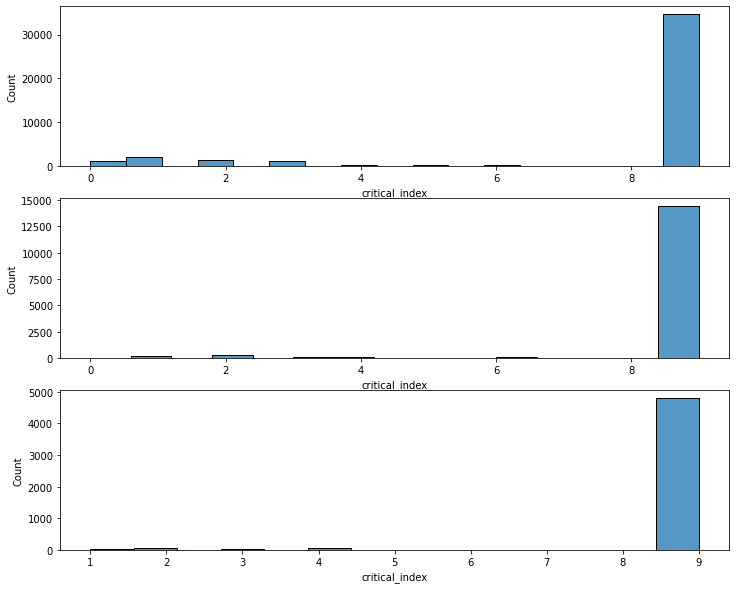

In [50]:
plt.figure(figsize=(12,10))
#plot destribution for yearly critical index
plt.subplot(3, 1, 1);
sns.histplot(data_process['critical_index'])

#plot destribution for monthly critical index
plt.subplot(3, 1, 2);
sns.histplot(data_process_monthly['critical_index'])

#plot destribution for weekly critical index
plt.subplot(3, 1, 3);
sns.histplot(data_process_weekly['critical_index'])


plt.show()

In [51]:
len(data_process_monthly.index)

15216

In [52]:
len(data_process_weekly.index)

4991

In [53]:
class RenameFeatures:
     #period 1-yearly, 2-monthly 3-weekly
    def __init__(self,period = 1):
        self.period = period
        
    def rename_features(self,x):
        if(self.period==2):
                x.drop(['payerIdTransformed', 'payerAccNo'], axis=1, inplace=True)
                x.rename(columns={'recency': 'm_recency',
                            'frequency': 'm_frequency',
                            'total_value': 'm_total_value',
                            'merchant_frequency':'m_merchant_frequency',
                            'tot_credit_card_trans':'m_tot_credit_card_trans',
                            'secure_3ds_count':'m_secure_3ds_count',
                            'success_3ds_count':'m_success_3ds_count',
                            'diff_brouser_count':'m_diff_brouser_count',
                            'status':'m_success_count',
                            'one_time_count':'m_one_time_count',
                            'lkr_trans':'m_lkr_trans',
                            'tot_bank_approves': 'm_tot_bank_approves',
                            'tot_bank_err': 'm_tot_bank_err',
                            'tot_invalid_card':'m_tot_invalid_card',
                            'tot_insufficient_fund':'m_tot_insufficient_fund',
                            'tot_bank_do_not_honor':'m_tot_bank_do_not_honor',
                            'tot_bank_lost_card':'m_tot_bank_lost_card',
                            'tot_amount_high':'m_tot_amount_high',
                            'tot_suspiciout_tm_trans':'m_tot_suspiciout_tm_trans',
                            'tot_high_risk_credit_trans':'m_tot_high_risk_credit_trans',
                            'success_count':'m_success_count',
                            'tot_success_amt':'m_tot_success_amt',
                            'success_percent':'m_success_percent',
                            'avg_success_amt':'m_avg_success_amt',
                            'avg_failed_amt':'m_avg_failed_amt',
                            'suspicious_failure_rate':'m_suspicious_failure_rate',
                            'sus_banker_res':'m_sus_banker_res',
                            'fail_3ds':'m_fail_3ds',
                            'suspicious_tm_trans':'m_suspicious_tm_trans',
                            'suspecious_credit_trans':'m_suspecious_credit_trans',
                            'sus_attempts_perday':'m_sus_attempts_perday',
                            'sus_attempts_perday_high_amounts':'m_sus_attempts_perday_high_amounts',
                            'sus_attempts_perday_high_sum':'m_sus_attempts_perday_high_sum',
                            'sus_attempts_perday_test_transactions':'m_sus_attempts_perday_test_transactions',
                            'critical_index':'m_critical_index' }, inplace=True)
                
                return x
        elif(self.period==3):
                x.drop(['payerIdTransformed', 'payerAccNo'], axis=1, inplace=True)
                x.rename(columns={'recency': 'w_recency',
                            'frequency': 'w_frequency',
                            'total_value': 'w_total_value',
                            'merchant_frequency':'w_merchant_frequency',
                            'tot_credit_card_trans':'w_tot_credit_card_trans',
                            'secure_3ds_count':'w_secure_3ds_count',
                            'success_3ds_count':'w_success_3ds_count',
                            'diff_brouser_count':'w_diff_brouser_count',
                            'status':'w_success_count',
                            'one_time_count':'w_one_time_count',
                            'lkr_trans':'w_lkr_trans',
                            'tot_bank_approves': 'w_tot_bank_approves',
                            'tot_bank_err': 'w_tot_bank_err',
                            'tot_invalid_card':'w_tot_invalid_card',
                            'tot_insufficient_fund':'w_tot_insufficient_fund',
                            'tot_bank_do_not_honor':'w_tot_bank_do_not_honor',
                            'tot_bank_lost_card':'w_tot_bank_lost_card',
                            'tot_amount_high':'w_tot_amount_high',
                            'tot_suspiciout_tm_trans':'w_tot_suspiciout_tm_trans',
                            'tot_high_risk_credit_trans':'w_tot_high_risk_credit_trans',
                            'success_count':'w_success_count',
                            'tot_success_amt':'w_tot_success_amt',
                            'success_percent':'w_success_percent',
                            'avg_success_amt':'w_avg_success_amt',
                            'avg_failed_amt':'w_avg_failed_amt',
                            'suspicious_failure_rate':'w_suspicious_failure_rate',
                            'sus_banker_res':'w_sus_banker_res',
                            'fail_3ds':'w_fail_3ds',
                            'suspicious_tm_trans':'w_suspicious_tm_trans',
                            'suspecious_credit_trans':'w_suspecious_credit_trans',
                            'sus_attempts_perday':'w_sus_attempts_perday',
                            'sus_attempts_perday_high_amounts':'w_sus_attempts_perday_high_amounts',
                            'sus_attempts_perday_high_sum':'w_sus_attempts_perday_high_sum',
                            'sus_attempts_perday_test_transactions':'w_sus_attempts_perday_test_transactions',
                            'critical_index':'w_critical_index'}, inplace=True)
                return x

In [54]:
data_process_monthly=RenameFeatures(period=2).rename_features(data_process_monthly)

In [55]:
data_process_weekly=RenameFeatures(period=3).rename_features(data_process_weekly)

In [56]:
data_process_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4991 entries, 0 to 4990
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   w_recency                                4991 non-null   int64  
 1   w_frequency                              4991 non-null   int64  
 2   w_total_value                            4991 non-null   float64
 3   w_merchant_frequency                     4991 non-null   int64  
 4   w_tot_credit_card_trans                  4991 non-null   int64  
 5   w_secure_3ds_count                       4991 non-null   int64  
 6   w_success_3ds_count                      4991 non-null   int64  
 7   w_diff_brouser_count                     4991 non-null   int64  
 8   w_success_count                          4991 non-null   int64  
 9   w_one_time_count                         4991 non-null   int64  
 10  w_lkr_trans                              4991 no

In [57]:
data_process = pd.merge(data_process,data_process_monthly,on='unique_id', how='left')

In [58]:
data_process = pd.merge(data_process,data_process_weekly,on='unique_id', how='left')

In [59]:
data_process.replace(np.nan, 0, inplace=True)

In [60]:
data_process.head(-100)

,payerIdTransformed,payerAccNo,recency,frequency,total_value,merchant_frequency,tot_credit_card_trans,secure_3ds_count,success_3ds_count,diff_brouser_count,...,w_suspicious_failure_rate,w_sus_banker_res,w_fail_3ds,w_suspicious_tm_trans,w_suspecious_credit_trans,w_sus_attempts_perday,w_sus_attempts_perday_high_amounts,w_sus_attempts_perday_high_sum,w_sus_attempts_perday_test_transactions,w_critical_index
0,170,4216892051,124,34,213542.0,34,0,0,0,34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,170,4691767287,256,6,611.0,6,0,0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,171,4157394003,261,3,30.0,3,0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,171,4216892051,235,6,561.0,6,0,0,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,172,4511936075,258,12,1316.0,12,0,0,0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,29228,5399211326,2,1,2600.0,1,0,1,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
41172,29229,5331403383,2,1,9092.0,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
41173,29230,5391574084,2,1,10000.0,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
41174,29231,4216893464,2,1,874.0,1,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


In [61]:
data_process.drop(["payerIdTransformed","payerAccNo"], inplace=True, axis=1)

In [62]:
 df['unique_id'] = df.payerIdTransformed.astype(str) + '_' + df.payerAccNo.astype(str)

In [63]:
data_set=pd.merge(df, data_process, on='unique_id', how='left')

In [64]:
transaction_count_threshold=10
transaction_count_threshold_month=5
def gen_critical_index_for_period(x,period=1):
    score = 9
    if(period==1 and x['frequency'] >= transaction_count_threshold):
        score= x['suspicious_failure_rate']+ x['sus_banker_res']+x['fail_3ds']+x['suspicious_tm_trans']+x['suspecious_credit_trans']+x['sus_attempts_perday']+x['sus_attempts_perday_high_amounts']+x['sus_attempts_perday_high_sum']+x['sus_attempts_perday_test_transactions']
        return score
    elif(period==2 and x['m_frequency'] >= transaction_count_threshold_month):
        score= x['m_suspicious_failure_rate']+ x['m_sus_banker_res']+x['m_fail_3ds']+x['m_suspicious_tm_trans']+x['m_suspecious_credit_trans']+x['m_sus_attempts_perday']+x['m_sus_attempts_perday_high_amounts']+x['m_sus_attempts_perday_high_sum']+x['m_sus_attempts_perday_test_transactions']
        return score
    elif(period==3 and x['w_frequency'] >= transaction_count_threshold_month):
        score= x['w_suspicious_failure_rate']+ x['w_sus_banker_res']+x['w_fail_3ds']+x['w_suspicious_tm_trans']+x['w_suspecious_credit_trans']+x['w_sus_attempts_perday']+x['w_sus_attempts_perday_high_amounts']+x['w_sus_attempts_perday_high_sum']+x['w_sus_attempts_perday_test_transactions']
        return score
    
    return score

In [65]:
def final_critical_index(x):
    score = 27
    if(x['frequency'] >= transaction_count_threshold ):
        score= x['critical_index']+ x['m_critical_index']+x['w_critical_index']
        return score
    else:
        return score

In [66]:
data_set['critical_index']=data_set.apply (lambda x: gen_critical_index_for_period(x,1), axis=1)
data_set['m_critical_index']=data_set.apply (lambda x: gen_critical_index_for_period(x,2), axis=1)
data_set['w_critical_index']=data_set.apply (lambda x: gen_critical_index_for_period(x,3), axis=1)
data_set.head()

,m_recency,m_frequency,m_total_value,m_merchant_frequency,m_tot_credit_card_trans,m_secure_3ds_count,m_success_3ds_count,m_diff_brouser_count,m_success_count,m_one_time_count,...,m_suspicious_failure_rate,m_sus_banker_res,m_fail_3ds,m_suspicious_tm_trans,m_suspecious_credit_trans,m_sus_attempts_perday,m_sus_attempts_perday_high_amounts,m_sus_attempts_perday_high_sum,m_sus_attempts_perday_test_transactions,m_critical_index
0,7,2,2776.0,2,2,0,0,2,2,0,...,0,0,0,0,0,0,0,0,0,9
1,6,1,3555.0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,9
2,24,4,20736.0,4,0,0,0,4,0,0,...,1,0,0,0,0,0,0,0,0,9
3,1,16,96828.0,16,0,0,0,16,0,0,...,1,0,0,0,0,1,0,0,0,2
4,21,3,11541.0,3,0,0,0,3,1,0,...,1,0,0,0,0,0,0,0,0,9


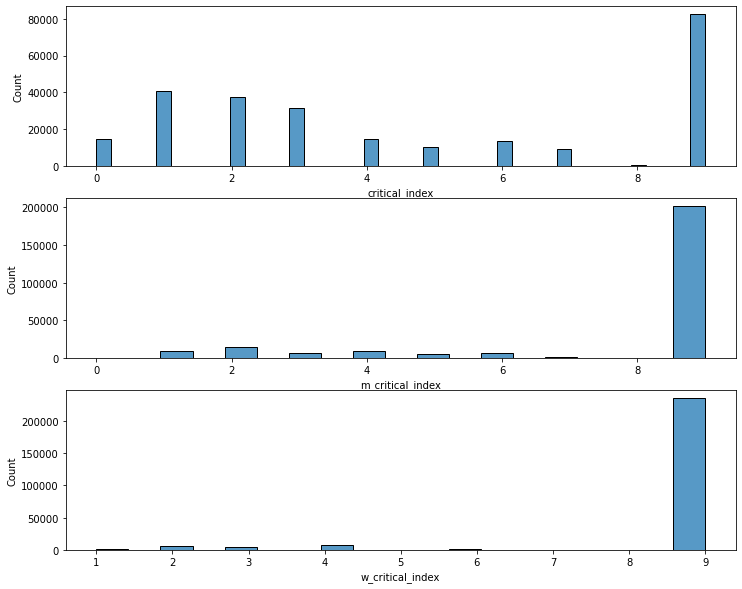

In [68]:
plt.figure(figsize=(12,10))
#plot destribution for yearly critical index
plt.subplot(3, 1, 1);
sns.histplot(data_set['critical_index'])

#plot destribution for monthly critical index
plt.subplot(3, 1, 2);
sns.histplot(data_set['m_critical_index'])

#plot destribution for weekly critical index
plt.subplot(3, 1, 3);
sns.histplot(data_set['w_critical_index'])


plt.show()

In [69]:
data_set['final_critical_index']=data_set.apply (lambda x: final_critical_index(x), axis=1)

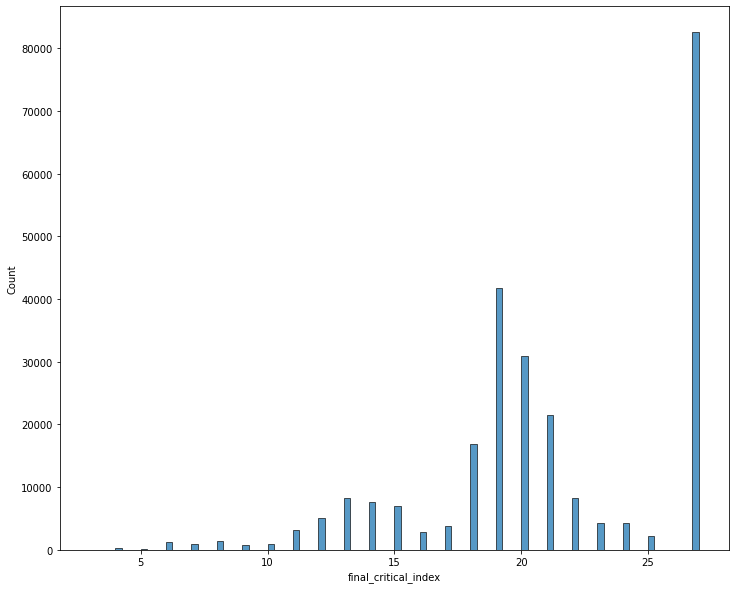

In [70]:
plt.figure(figsize=(12,10))
#plot destribution for yearly critical index
sns.histplot(data_set['final_critical_index'])
plt.show()

In [71]:
data_set.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256294 entries, 0 to 256293
Data columns (total 132 columns):
 #    Column                                   Non-Null Count   Dtype         
---   ------                                   --------------   -----         
 0    Unnamed: 0                               256294 non-null  int64         
 1    payerAccountNumber                       256294 non-null  int64         
 2    payerIdTransformed                       256294 non-null  int64         
 3    payeeIdTransformed                       256294 non-null  int64         
 4    originalAmount                           256294 non-null  float64       
 5    createdAt                                256294 non-null  datetime64[ns]
 6    transaction_date                         256294 non-null  object        
 7    transaction_time                         256294 non-null  object        
 8    issuer_bank                              256294 non-null  int64         
 9    ip_address   

In [72]:
data_set.to_csv('features_generated_filtered.csv',index=False)

In [73]:
int_vars = ['suspicious_failure_rate','sus_banker_res','fail_3ds','suspicious_tm_trans','suspecious_credit_trans','sus_attempts_perday','sus_attempts_perday_high_amounts','sus_attempts_perday_high_sum','sus_attempts_perday_test_transactions',
            'm_suspicious_failure_rate','m_sus_banker_res','m_fail_3ds','m_suspicious_tm_trans','m_suspecious_credit_trans','m_sus_attempts_perday','m_sus_attempts_perday_high_amounts','m_sus_attempts_perday_high_sum','m_sus_attempts_perday_test_transactions',
            'w_suspicious_failure_rate','w_sus_banker_res','w_fail_3ds','w_suspicious_tm_trans','w_suspecious_credit_trans','w_sus_attempts_perday','w_sus_attempts_perday_high_amounts','w_sus_attempts_perday_high_sum','w_sus_attempts_perday_test_transactions']
data_set.replace([np.inf, -np.inf], np.nan)
data_set = data_set.fillna(0)
data_set[int_vars] = data_set[int_vars].astype(int) 

In [74]:
scaler = StandardScaler()
#data_set.drop(["payerAccNo","unique_id"], inplace=True, axis=1)
#data_set.dropna(axis=1, how='all')
#data_set.replace(np.inf, 0, inplace=True)
#data_set.replace([np.inf, -np.inf], np.nan)
data_set['createdAt']=pd.to_datetime(data_set.createdAt)
data_set['createdAt'] = data_set.createdAt.values.astype(np.int64)
data_set['transaction_date']=pd.to_datetime(data_set.transaction_date)
data_set['transaction_time']=pd.to_datetime(data_set.transaction_time)
data_set['transaction_date'] = data_set['transaction_date'].apply(lambda x: x.value)
data_set['transaction_time'] = data_set['transaction_time'].apply(lambda x: x.value)

cat_vars = ['funding_method','secure_3ds','success_3ds','status','type','currency','amount_high','suspicious_time','high_risk_credit_transaction','bank_approved','bank_err','bank_invalid_card','bank_insufficient_fund','bank_do_not_honor','bank_lost_card','channel_visa','channel_master','channel_amex',
            'initialized_api','initialized_session','initialized_plugin','initialized_ext_api','initialized_ipg','is_fraud']

#data_set[cat_vars] = data_set[cat_vars].astype(str) 

#avg_failed_amt,m_avg_failed_amt,w_avg_failed_amt
con_vars = ['payerAccountNumber','payerIdTransformed','payeeIdTransformed','originalAmount','createdAt','transaction_date','transaction_time','issuer_bank','ip_address','browser',
           'recency','frequency','total_value','merchant_frequency','secure_3ds_count','success_3ds_count','diff_brouser_count','success_count','one_time_count','lkr_trans','tot_amount_high','tot_suspiciout_tm_trans','tot_high_risk_credit_trans',
            'tot_bank_approves','tot_bank_err','tot_invalid_card','tot_insufficient_fund','tot_bank_do_not_honor','tot_bank_lost_card','tot_success_amt',
           'success_percent','avg_success_amt','tot_credit_card_trans',
           'm_recency','m_frequency','m_total_value','m_merchant_frequency','m_secure_3ds_count','m_success_3ds_count','m_diff_brouser_count','m_success_count','m_one_time_count','m_lkr_trans','m_tot_amount_high','m_tot_suspiciout_tm_trans','m_tot_high_risk_credit_trans','m_tot_bank_approves','m_tot_bank_err','m_tot_invalid_card','m_tot_insufficient_fund',
           'm_tot_bank_do_not_honor','m_tot_bank_lost_card','m_tot_success_amt','m_success_percent','m_avg_success_amt','m_tot_credit_card_trans', 
          'w_recency','w_frequency','w_total_value','w_merchant_frequency','w_secure_3ds_count','w_success_3ds_count','w_diff_brouser_count','w_success_count','w_one_time_count','w_lkr_trans','w_tot_amount_high','w_tot_suspiciout_tm_trans','w_tot_high_risk_credit_trans',
          'w_tot_bank_approves','w_tot_bank_err','w_tot_invalid_card','w_tot_insufficient_fund','w_tot_bank_do_not_honor','w_tot_bank_lost_card','w_tot_success_amt','w_success_percent','w_avg_success_amt','w_tot_credit_card_trans',
            
            'final_critical_index']

#data_set.fillna(data_set.mean(), inplace=True)

#numeric_cols = list(data_set.dtypes[data_set.dtypes != 'object'].index)
#data_set.loc[:,numeric_cols] = scaler.fit_transform(data_set.loc[:,numeric_cols])
#data_set[numeric_cols]  =round(data_set[numeric_cols],10)

data_set[con_vars]=scaler.fit_transform(data_set[con_vars])
data_set[con_vars]  =round(data_set[con_vars],10)
data_set.drop(["Unnamed: 0","avg_failed_amt","m_avg_failed_amt","w_avg_failed_amt","critical_index","m_critical_index","w_critical_index","unique_id","payerAccNo"], inplace=True, axis=1)
data_set.to_csv('feature_engineering_filtered_standerdize.csv',index=False)
#data_set.info()

In [75]:
data_set.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256294 entries, 0 to 256293
Data columns (total 123 columns):
 #    Column                                   Non-Null Count   Dtype  
---   ------                                   --------------   -----  
 0    payerAccountNumber                       256294 non-null  float64
 1    payerIdTransformed                       256294 non-null  float64
 2    payeeIdTransformed                       256294 non-null  float64
 3    originalAmount                           256294 non-null  float64
 4    createdAt                                256294 non-null  float64
 5    transaction_date                         256294 non-null  float64
 6    transaction_time                         256294 non-null  float64
 7    issuer_bank                              256294 non-null  float64
 8    ip_address                               256294 non-null  float64
 9    browser                                  256294 non-null  float64
 10   funding_method    

In [77]:
channel_visa                             256294 non-null  int64  
 26   channel_master                           256294 non-null  int64  
 27   channel_amex                             256294 non-null  int64  
 28   initialized_api                          256294 non-null  int64  
 29   initialized_session                      256294 non-null  int64  
 30   initialized_plugin                       256294 non-null  int64  
 31   initialized_ext_api                      256294 non-null  int64  
 32   initialized_ipg     
    
    m_tot_channel_master                     256294 non-null  float64
 93   m_tot_channel_visa                       256294 non-null  float64
 94   m_tot_channel_amex                       256294 non-null  float64
 95   m_tot_api                                256294 non-null  float64
 96   m_tot_session                            256294 non-null  float64
 97   m_tot_plugin                             256294 non-null  float64
 98   m_tot_ext_api                            256294 non-null  float64
 99   m_tot_ipg       

 tot_channel_master                       256294 non-null  float64
 54   tot_channel_visa                         256294 non-null  float64
 55   tot_channel_amex                         256294 non-null  float64
 56   tot_api                                  256294 non-null  float64
 57   tot_session                              256294 non-null  float64
 58   tot_plugin                               256294 non-null  float64
 59   tot_ext_api                              256294 non-null  float64
 60   tot_ipg      


w_tot_channel_master                     256294 non-null  float64
 132  w_tot_channel_visa                       256294 non-null  float64
 133  w_tot_channel_amex                       256294 non-null  float64
 134  w_tot_api                                256294 non-null  float64
 135  w_tot_session                            256294 non-null  float64
 136  w_tot_plugin                             256294 non-null  float64
 137  w_tot_ext_api                            256294 non-null  float64
 138  w_tot_ipg          

SyntaxError: invalid syntax (<ipython-input-77-34cc44bdf50a>, line 1)